### Fitting OCCAM clusters.

This notebook is about using PCA to identify directions, in latent spaces, along which open clusters vary.

**TO DO**

- Incorporate the pca transforms into the latentvector framework somehow.

- Include tools for studying the explained variance in a chosen direction of hyperspace.

- Include tools for plotting cluster breakdowns along random directions.

- Create scatterplot of pred vs true paramters but for occam stars and check if results are consistent with training dataset values

### Setup

Importing all the required modules

In [1]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset
from apoNN.src.utils import generate_loss_with_masking
from apoNN.src.utils import dump
from apoNN.src.utils import load
import apoNN.src.vectors as vector

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

## Loading datasets


We load all of our different datasets

In [2]:
n_data=2000

In [3]:
occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = ApogeeDataset(allStar_occam,outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"]

In [4]:
allStar_behaved_restricted =  load("allStar_behaved_restricted")
dataset_behaved_restricted =  ApogeeDataset(filename="behaved_restricted",outputs = ["aspcap","mask","physical","idx"])

In [5]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar_behaved_restricted[param] for param in considered_parameters])[:,:n_data].T)

In [6]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/z10/ae_7600.p")


### Creating vectors from datasets

In [7]:
#z_behaved_restricted = LatentVector(dataset_behaved_restricted,autoencoder,len(dataset_behaved_restricted))
z_behaved_restricted = vector.LatentVector(dataset_behaved_restricted,autoencoder,n_data)

In [8]:
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))

### Setting up PCA

We run two separate PCAs.

* ```whitening_pca``` is used to whiten/sphere the dataset. That is to say scale by the eigenvalues so each data direction has equal variance.


* ```cluster_pca``` is applied on the whitened dataset and is used to identify the hyperplane in which stars sharing the same open cluster are embedded.

In [9]:
whitening_pca  = PCA(n_components=10,whiten=True)
cluster_pca = PCA(n_components=10)

In [10]:
whitening_pca.fit(z_behaved_restricted.centered)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [11]:
#cluster_pca.fit(whitening_pca.transform(z_behaved_restricted.centered[1000:1400]))
cluster_pca.fit(whitening_pca.transform(z_occam.cluster_centered))

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

We've created ```vector.get_var(data,direction)``` to calculate the variance along any chosen direction

In [89]:
whitening_pca.explained_variance_

array([0.7995321 , 0.59039176, 0.5250723 , 0.35073656, 0.30085   ,
       0.09749378, 0.03114839, 0.01044665, 0.00278981, 0.00113656],
      dtype=float32)

In [90]:
vector.get_vars(z_behaved_restricted.centered,whitening_pca.components_)

array([0.79913306, 0.5900967 , 0.5248101 , 0.35056108, 0.3006996 ,
       0.09744509, 0.03113281, 0.01044144, 0.00278841, 0.00113599],
      dtype=float32)

we see that our functions outputs agree with those obtained from scikitlearns PCA.

### Linear and Non-linear transformations

We've written some functions for learning linear and non-linear transformations from the latents to parameters of interest

In [19]:
w = vector.LinearTransformation(z_behaved_restricted,y)

In [20]:
nonlinear_w = vector.NonLinearTransformation(z_behaved_restricted,y)
nonlinear_w.fit(n_epochs=100)

err:0.10863105952739716
err:0.09978828579187393
err:0.11517373472452164
err:0.0981789231300354
err:0.09224281460046768
err:0.09424792230129242
err:0.07181894034147263
err:0.07165633141994476
err:0.07009170949459076
err:0.06625840812921524
err:0.05783691629767418
err:0.05632772669196129
err:0.05487940460443497
err:0.04384806379675865
err:0.062184348702430725
err:0.049064647406339645
err:0.040540989488363266
err:0.03934827074408531
err:0.030753057450056076
err:0.037373799830675125
err:0.03934323787689209
err:0.03902803361415863
err:0.048402827233076096
err:0.044966019690036774
err:0.03946852311491966
err:0.044331055134534836
err:0.03457443416118622
err:0.03606634587049484
err:0.03721217066049576
err:0.03711627423763275
err:0.03097815252840519
err:0.0323333777487278
err:0.03540794551372528
err:0.027911001816391945
err:0.03794815018773079
err:0.03162893280386925
err:0.027751542627811432
err:0.026945756748318672
err:0.021743036806583405
err:0.027881553396582603
err:0.02760765515267849
err:0

err:0.02047070860862732
err:0.029888629913330078
err:0.022587986662983894
err:0.020408086478710175
err:0.020069262012839317
err:0.01616394706070423
err:0.021366851404309273
err:0.02218502387404442
err:0.023100269958376884
err:0.029249941930174828
err:0.02972799353301525
err:0.02354029007256031
err:0.02634590119123459
err:0.021837230771780014
err:0.02288467064499855
err:0.023696912452578545
err:0.028325431048870087
err:0.024222133681178093
err:0.02278689481317997
err:0.026550814509391785
err:0.020341161638498306
err:0.029711587354540825
err:0.0224395003169775
err:0.02028479054570198
err:0.01991519331932068
err:0.016046717762947083
err:0.021252475678920746
err:0.02208538167178631
err:0.02293439209461212
err:0.029049377888441086
err:0.02956877090036869
err:0.023377250880002975
err:0.026138199493288994
err:0.021678445860743523
err:0.022734295576810837
err:0.023557797074317932
err:0.02817627601325512
err:0.02410670928657055
err:0.022644205018877983
err:0.02640964649617672
err:0.020220244303

err:0.02255379967391491
err:0.02124437503516674
err:0.0249068271368742
err:0.018886668607592583
err:0.02724790945649147
err:0.020674776285886765
err:0.019016845151782036
err:0.018115706741809845
err:0.014764714986085892
err:0.020057322457432747
err:0.02072896808385849
err:0.021230261772871017
err:0.026709627360105515
err:0.02794117107987404
err:0.021770013496279716
err:0.023810705170035362
err:0.019858315587043762
err:0.021047091111540794
err:0.022066235542297363
err:0.02635338343679905
err:0.022480376064777374
err:0.021193727850914
err:0.02485186606645584
err:0.01883642002940178
err:0.027135834097862244
err:0.02060532197356224
err:0.018966196104884148
err:0.01804828643798828
err:0.014723203144967556
err:0.02001809887588024
err:0.02066657319664955
err:0.021174471825361252
err:0.026618700474500656
err:0.027887873351573944
err:0.02172083593904972
err:0.02372570149600506
err:0.01979038678109646
err:0.020985601469874382
err:0.022009292617440224
err:0.026277834549546242
err:0.02240874990820

err:0.027098869904875755
err:0.021112194284796715
err:0.0225745290517807
err:0.01891721412539482
err:0.02023587003350258
err:0.021237732842564583
err:0.02526034228503704
err:0.021410949528217316
err:0.02051481232047081
err:0.024026839062571526
err:0.018130842596292496
err:0.02547113597393036
err:0.019657617434859276
err:0.01825421303510666
err:0.017098791897296906
err:0.014189056120812893
err:0.019502291455864906
err:0.019809141755104065
err:0.020336126908659935
err:0.025277961045503616
err:0.02706398069858551
err:0.02108544111251831
err:0.022516220808029175
err:0.018876902759075165
err:0.020202673971652985
err:0.021203581243753433
err:0.025211678817868233
err:0.02135860174894333
err:0.020487356930971146
err:0.023992173373699188
err:0.01809919998049736
err:0.0253902580589056
err:0.01961270347237587
err:0.0182194784283638
err:0.01705835573375225
err:0.014167962595820427
err:0.019479284062981606
err:0.019769614562392235
err:0.02029675990343094
err:0.02521492727100849
err:0.02702757529914

err:0.019706951454281807
err:0.024226956069469452
err:0.026461176574230194
err:0.020684218034148216
err:0.02165706641972065
err:0.018308725208044052
err:0.019719913601875305
err:0.020672881975769997
err:0.02439519390463829
err:0.020634928718209267
err:0.020049456506967545
err:0.023466795682907104
err:0.017585840076208115
err:0.024123866111040115
err:0.018994109705090523
err:0.017696158960461617
err:0.016438288614153862
err:0.01385939959436655
err:0.019111134111881256
err:0.019117308780550957
err:0.019679289311170578
err:0.024175459519028664
err:0.026430940255522728
err:0.02066670171916485
err:0.02161707915365696
err:0.01828060857951641
err:0.019703181460499763
err:0.02064691297709942
err:0.024354038760066032
err:0.020603954792022705
err:0.020030133426189423
err:0.02344205230474472
err:0.01756013184785843
err:0.02405763790011406
err:0.01896650716662407
err:0.01766848936676979
err:0.016409307718276978
err:0.013845933601260185
err:0.01909402571618557
err:0.01908276602625847
err:0.01964769

err:0.013656285591423512
err:0.01879804953932762
err:0.018536869436502457
err:0.019175276160240173
err:0.02333691343665123
err:0.02597322128713131
err:0.02035197615623474
err:0.020963916555047035
err:0.017839469015598297
err:0.019387604668736458
err:0.020196113735437393
err:0.023656582459807396
err:0.020113421604037285
err:0.01968706212937832
err:0.023039834573864937
err:0.01714440807700157
err:0.02306373417377472
err:0.018530379980802536
err:0.017243314534425735
err:0.015980273485183716
err:0.013646717183291912
err:0.018783261999487877
err:0.01850731484591961
err:0.019151942804455757
err:0.02329450100660324
err:0.025952773168683052
err:0.020337603986263275
err:0.020933523774147034
err:0.01781913824379444
err:0.01937299408018589
err:0.02017410285770893
err:0.0236212108284235
err:0.020087378099560738
err:0.01967323012650013
err:0.023021534085273743
err:0.017122529447078705
err:0.023011991754174232
err:0.0185066107660532
err:0.017222825437784195
err:0.0159582681953907
err:0.0136350821703

Text(0.5, 1.0, 'Teff')

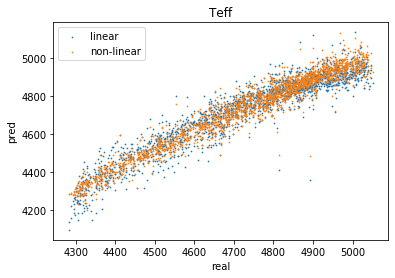

In [21]:
i=0
plt.scatter(y.raw[:,i],w.predict(z_behaved_restricted).raw[:,i],s=0.5,label="linear")
plt.scatter(y.raw[:,i],nonlinear_w.predict(z_behaved_restricted).raw[:,i],s=0.5,label="non-linear")
plt.legend()
plt.xlabel("real")
plt.ylabel("pred")
plt.title(considered_parameters[i])

### Whitened linear transformation

Because our open-cluster hyperplanes operate on the whitened latents. It is easier to just learn these transformations there.

In [32]:
whitened_z = vector.Vector(whitening_pca.transform(z_behaved_restricted.centered))

In [33]:
whitened_w = vector.LinearTransformation(whitened_z,y)

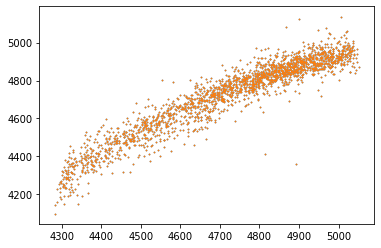

In [34]:
plt.scatter(y.raw[:,i],whitened_w.predict(whitened_z).raw[:,i],s=0.5,label="linear")
plt.scatter(y.raw[:,i],w.predict(z_behaved_restricted).raw[:,i],s=0.5,label="linear")


### Comparing PCA and LinearTransformation directions 

An interesting question is to measure how much variance is captured by each parameters linear directions in latent space.

In [73]:
whitened_occam_z = vector.Vector(whitening_pca.transform(z_occam.centered))

In [74]:
whitened_z = vector.Vector(whitening_pca.transform(z_behaved_restricted.centered))

In [75]:
vector.get_vars(whitened_z.centered,whitened_w.val)

array([3.6361559e+04, 1.0894585e-01, 5.4831069e-02, 5.4293438e-03,
       8.2260015e-04, 6.6482886e-03, 3.4091070e-03, 1.9331017e-03,
       4.9248477e-03, 2.9743069e-03, 3.1322157e-03, 2.2149076e-04],
      dtype=float32)

In [76]:
norm_test = whitened_w.val/np.linalg.norm(whitened_w.val,axis=1)[:,None]

In [77]:
vector.get_vars(whitened_z.centered,norm_test)

array([0.99949974, 0.99950016, 0.99950004, 0.9994996 , 0.99949986,
       0.9994999 , 0.9994997 , 0.99949986, 0.9994999 , 0.9995004 ,
       0.9995006 , 0.9995    ], dtype=float32)

(array([ 12.,  73., 189., 399., 546., 405., 236.,  98.,  32.,  10.]),
 array([-3.0037775 , -2.358142  , -1.7125063 , -1.0668706 , -0.421235  ,
         0.22440064,  0.87003624,  1.5156718 ,  2.1613076 ,  2.8069432 ,
         3.4525788 ], dtype=float32),
 <a list of 10 Patch objects>)

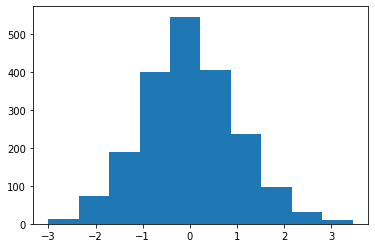

In [84]:
plt.hist(whitened_z.centered[:,0])

(array([199.,  11.,   8.,   6.,   1.,   2.,   0.,   2.,   0.,   1.]),
 array([-3.0617392,  0.6383194,  4.338378 ,  8.038437 , 11.738495 ,
        15.438554 , 19.138613 , 22.83867  , 26.538729 , 30.238789 ,
        33.938847 ], dtype=float32),
 <a list of 10 Patch objects>)

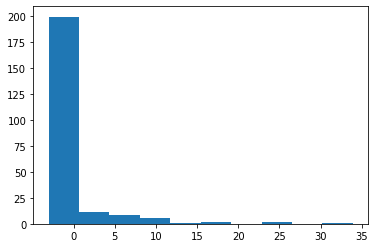

In [86]:
plt.hist(whitened_occam_z.centered[:,0])

In [78]:
vector.get_vars(whitened_occam_z.centered,norm_test)

array([239.96892 , 230.8446  ,  44.942238, 161.47678 , 492.89294 ,
       565.4948  , 129.8861  ,  70.876915,  53.06208 ,  43.886543,
       533.81525 ,  97.45372 ], dtype=float32)

In [80]:
whitened_z.centered.shape

(2000, 10)

### Investigating individual clusters

In [ ]:
z_occam.registry

In [ ]:
#clust_idxs =z_occam.registry['NGC 7789']
clust_idxs =z_occam.registry["NGC 2682"]

In [ ]:
clust_idxs

In [ ]:
z_occam.plot_rec(clust_idxs[0],[2000,2900])

Have abundances been calibrated based on these clusters. This could make APOGEE pipeline results look better then they are.

In [ ]:
i=3
elem = considered_parameters[i]
plt.hist(z_occam.dataset.allStar[clust_idxs][elem],bins=5)
plt.hist(z_occam.dataset.allStar[elem],bins=50,alpha=0.2)
plt.title(elem)
plt.xlim(-1,1)

In [ ]:
plt.hist(w.predict(z_occam).raw[:,i][clust_idxs],bins=5)
plt.hist(w.predict(z_occam).raw[:,i],bins=500,alpha=0.2)
plt.xlim(-1,1)
plt.title(considered_parameters[i])

In [ ]:
plt.hist(nonlinear_w.predict(z_occam).raw[:,i][clust_idxs],bins=5)
plt.hist(nonlinear_w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
plt.xlim(-1,1)
plt.title(considered_parameters[i])

### Sandbox

In [ ]:
y.normalized


In [ ]:
nonlinear_w.fit(n_epochs=500)

In [ ]:
i=2
plt.scatter(y.raw[:,i],nonlinear_w.predict(z_behaved_restricted).raw[:,i],s=0.5,label="non_linear")
plt.scatter(y.raw[:,i],w.predict(z_behaved_restricted).raw[:,i],s=0.5,label="linear")
plt.legend()
plt.xlabel("real")
plt.ylabel("pred")
plt.title(considered_parameters[i])

In [ ]:
nonlinear_w.pred()

In [ ]:
y.centered.shape

In [ ]:
np.mean(y.centered,0)

In [ ]:
y.centered

In [ ]:
plt.hist((y.centered/np.max(y.centered,0))[:,2])

In [ ]:
from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder


In [ ]:
structure = [z_behaved_restricted.centered.shape[1],256,256,y.centered.shape[1]]
structure

In [ ]:
feedforward  = Feedforward(structure,activation=nn.SELU()).to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(feedforward.parameters(),lr=0.0001)

In [ ]:
idx_loader = torch.utils.data.DataLoader(torch.arange(y.centered.shape[0]),batch_size=20)

In [ ]:
for i in idx_loader:
    break

In [ ]:
torch.tensor(y.centered[i])

In [ ]:
z_behaved_restricted,y

In [ ]:
z_behaved_restricted

In [ ]:
def create_multipliers():
    func = [lambda x : i * x for i in range(6)]
    i=9
    return func


In [ ]:
for multiplier in create_multipliers():
    print(multiplier(2))